<a href="https://colab.research.google.com/github/sunheehee/kaggle-study/blob/main/%5Bkaggle%5D_AU_rain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.kaggle.com/code/karnikakapoor/rain-prediction-ann/notebook

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    precision_score, recall_score, confusion_matrix,
    classification_report, accuracy_score, f1_score
)

from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout, LSTM
from keras.utils import to_categorical
from keras.optimizers import Adam
from tensorflow.keras import regularizers
from keras import callbacks

np.random.seed(0)


# Loading Data

In [ ]:
df=pd.read_csv('/content/drive/MyDrive/DArt-B 5기/kaggle study/weatherAUS.csv')
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


**데이터에 대하여:**

이 데이터셋은 호주 전역의 다양한 지역의 기상 관측소에서 수집된 약 10년치의 일일 기상 관측 데이터를 포함하고 있습니다.

이 프로젝트에서는 이 데이터를 활용해
다음 날 비가 올지 여부(RainTomorrow)를 예측하는 모델을 만들 예정입니다.

이 데이터에는 "RainTomorrow"라는 타깃 변수를 포함해 총 23개의 속성이 있으며, 이는 다음 날 비가 올지를 나타냅니다.





In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

✔️ 결측치 있음

✔️ 수치형과 범주현 변수가 포함되어있음

# Data Visualization and Cleaning



*  타깃 열에 대한 카운트 플롯 ✅ 클래스 불균형 확인
*  숫자형 속성들 간의 상관관계 분석
- 날짜 데이터를 datetime 형식으로 변환
- 요일과 월을 연속적인 주기적(cyclic) 특징으로 인코딩


<ipython-input-4-d1f3590ba919>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df['RainTomorrow'], palette=cols)


<Axes: xlabel='RainTomorrow', ylabel='count'>

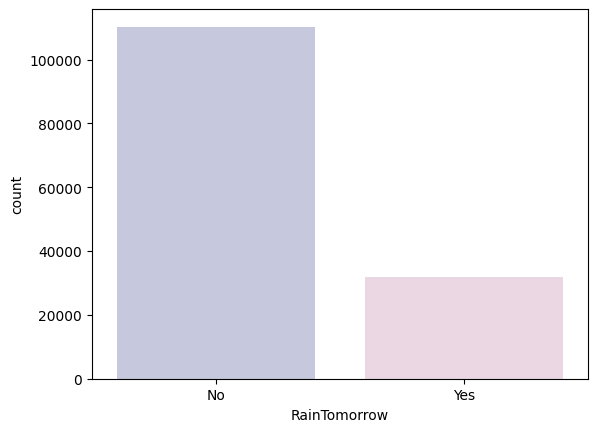

In [ ]:
# 클래스 불균형 확인
cols= ["#C2C4E2","#EED4E5"]
sns.countplot(x=df['RainTomorrow'], palette=cols)

<Axes: >

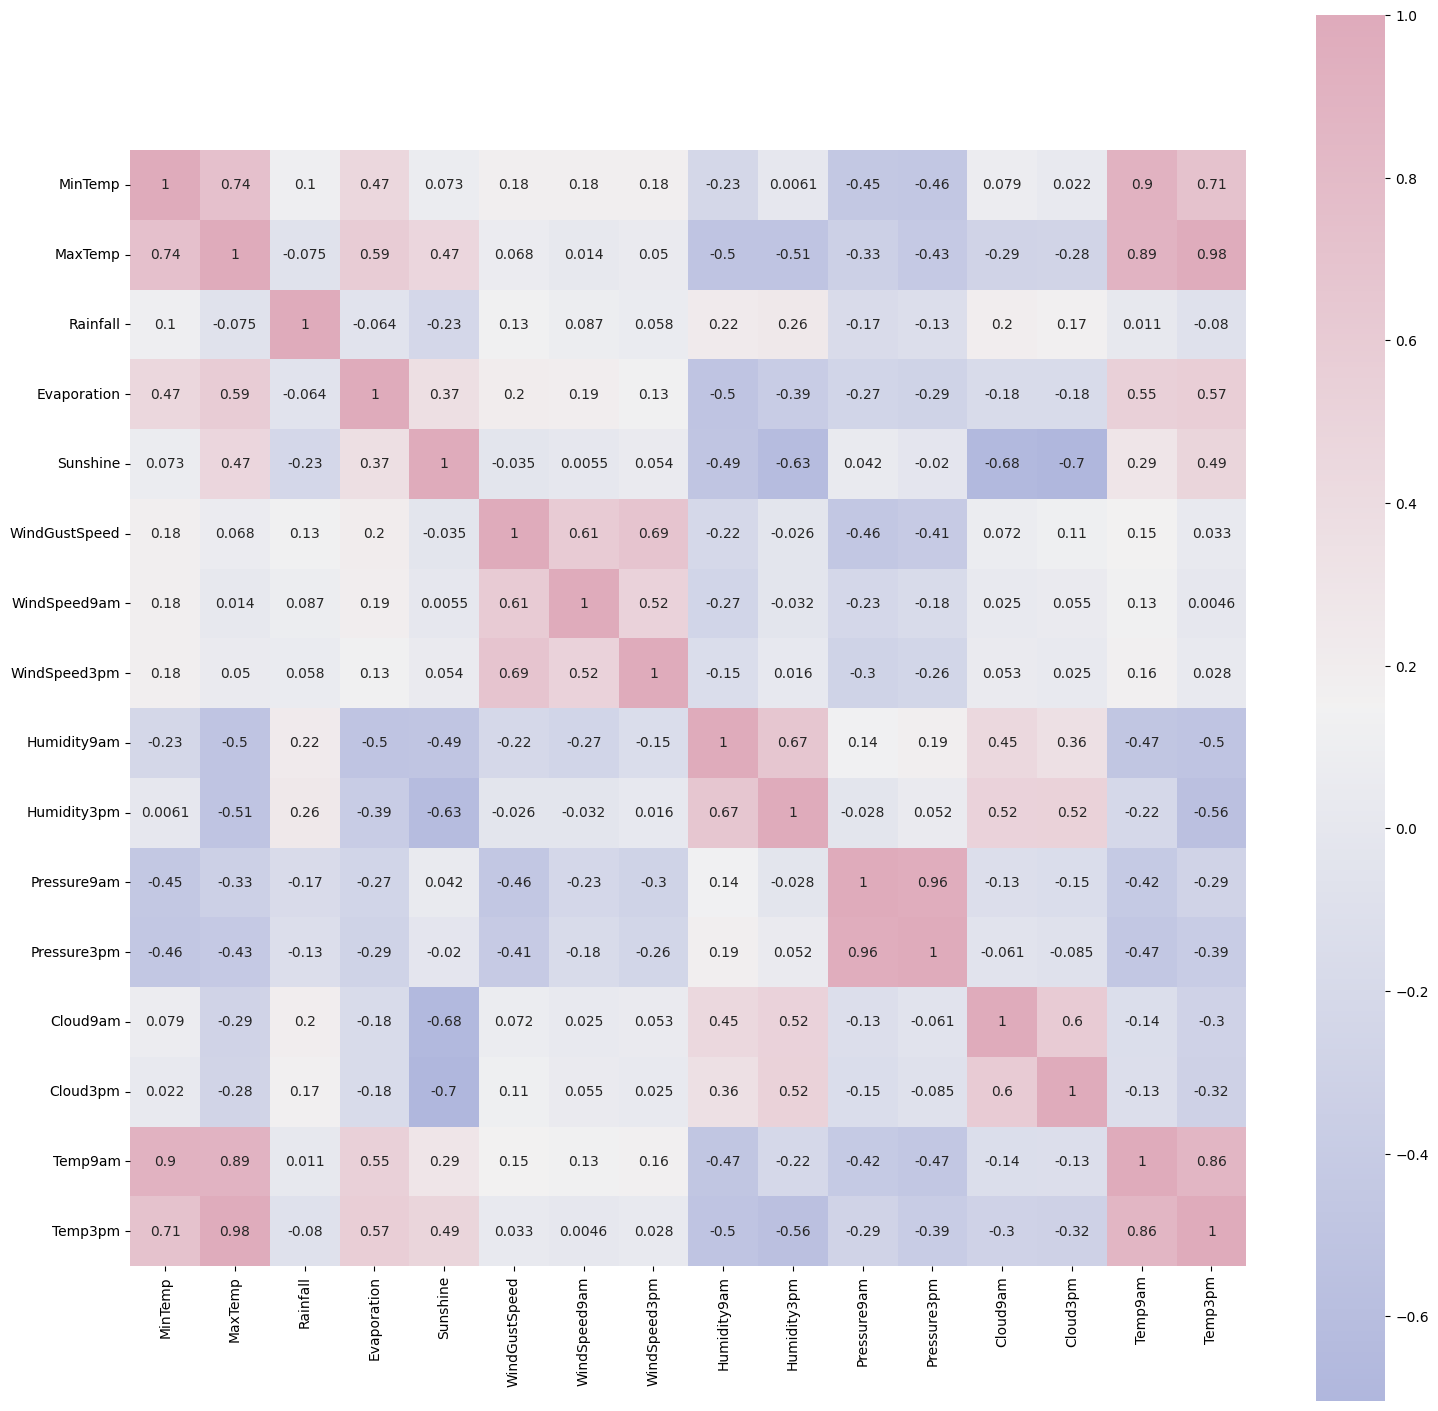

In [ ]:
num_df=df.select_dtypes(exclude='object')
corrmat=num_df.corr()
cmap = sns.diverging_palette(260,-10,s=50,l=75,n=6,as_cmap=True)
plt.subplots(figsize=(18,18))
sns.heatmap(corrmat,cmap=cmap, annot=True, square=True)

✔️diverging_palette(h_neg,h_pos,s=75,l=50,n=6,as_cmap=True)

양 극단의 값을 서로 다른 색상으로 표현하고, 중간값에 가까울수록 중간색을 사용하는 색상 팔레트임

- h_neg:음수값에 대응되는 색상
- h_pos:양수값에 대응되는 색상
- s: 색상의 선명도
- l: 밝기
- n: 생성할 색상 단계 수
- as_cmap = True : matplotlib 컬러맵 형태로 반환

## parsing datetime

날짜를 datetime 형식으로 변환할 것이다.

나의 목표는 인공 신경망을 구축하는 것이다.
그래서 날짜를 적절하게 인코딩하려고 한다.
즉, 월과 일을 주기적인 연속형 특징으로 표현하고자 한다.
왜냐하면 날짜와 시간은 본질적으로 주기적이기 때문이다.

신경망 모델이 해당 특징이 주기적이라는 것을 인식하도록 하기 위해,
나는 날짜를 주기적인 하위 요소들로 나누었다.
즉, 연도, 월, 일로 구분하였다.

그리고 각 하위 요소마다,
사인 변환과 코사인 변환을 적용한 두 개의 새로운 특징을 생성하였다.

In [ ]:
#datetime으로 변환
lengths = df['Date'].str.len()
lengths.value_counts()

,count
Date,
10,145460


✔️ Data컬럼의 145460개의 행의 길이가 모두 10자로, 날짜형식이 일정함을 확인

➡️ error가 없어서 pd.to_datetime()으로 안전하게 변환 가능

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])

#'Year'변수 생성(Date컬럼에서 Year만 별도 컬럼으로 추출)
df['Year'] = df.Date.dt.year

In [ ]:
# 날짜 관련 컬럼을 신경망에 입력할 수 있도록 주기성을 부여하는 함수 정의
# 예시: 12월과 1월은 숫자상 11개월 차이나는 것 같지만, 실제로는 1달 차이 → SIN,COS를 이용해서 연속적이면서 순환 구조를 표현
def encode(df,col,max_val):
    df[col+'_sin'] = np.sin(2*np.pi*df[col]/max_val)
    df[col+'_cos'] = np.cos(2*np.pi*df[col]/max_val)
    return df

In [ ]:
df['month'] = df.Date.dt.month
df = encode(df,'month', 12)

df['day'] = df.Date.dt.day
df=encode(df,'day',31)

df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Temp3pm,RainToday,RainTomorrow,Year,month,month_sin,month_cos,day,day_sin,day_cos
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,21.8,No,No,2008,12,-2.449294e-16,1.0,1,0.201299,0.979530
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,24.3,No,No,2008,12,-2.449294e-16,1.0,2,0.394356,0.918958
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,23.2,No,No,2008,12,-2.449294e-16,1.0,3,0.571268,0.820763
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,26.5,No,No,2008,12,-2.449294e-16,1.0,4,0.724793,0.688967
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,29.7,No,No,2008,12,-2.449294e-16,1.0,5,0.848644,0.528964


Text(0.5, 0, 'Days in Year')

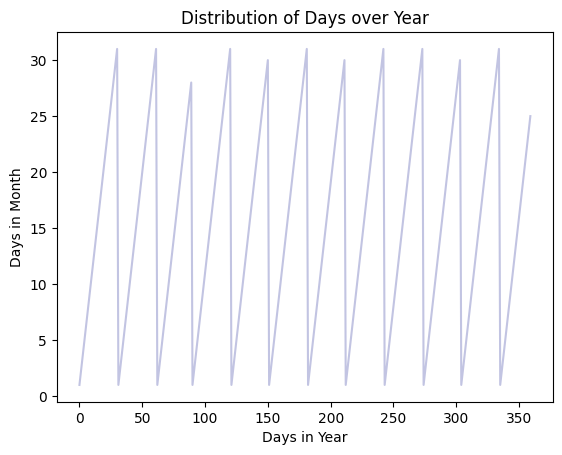

In [ ]:
# 약 1년동안의 구간 설정
section = df[:360] # 2008년 12월 1일부터 날짜순으로 정렬되어있음 ▶ 2009년 11월 25까지의 데이터일 가능성이
tm = section['day'].plot(color="#C2C4E2")   #day컬럼(1~31일)의 값을 시계열로 시각
tm.set_title('Distribution of Days over Year')
tm.set_ylabel('Days in Month')  # 날짜
tm.set_xlabel('Days in Year')   # 일(day)

✔️ 한 해 동안 달이 어떻게 넘어가는지를 시각적으로 보여줌

✅ 날짜 순환 구조가 잘 작동하고 있는지,

✅ 날짜 정보가 정상적으로 들어갔는지를 한눈에 확인하기 용이함

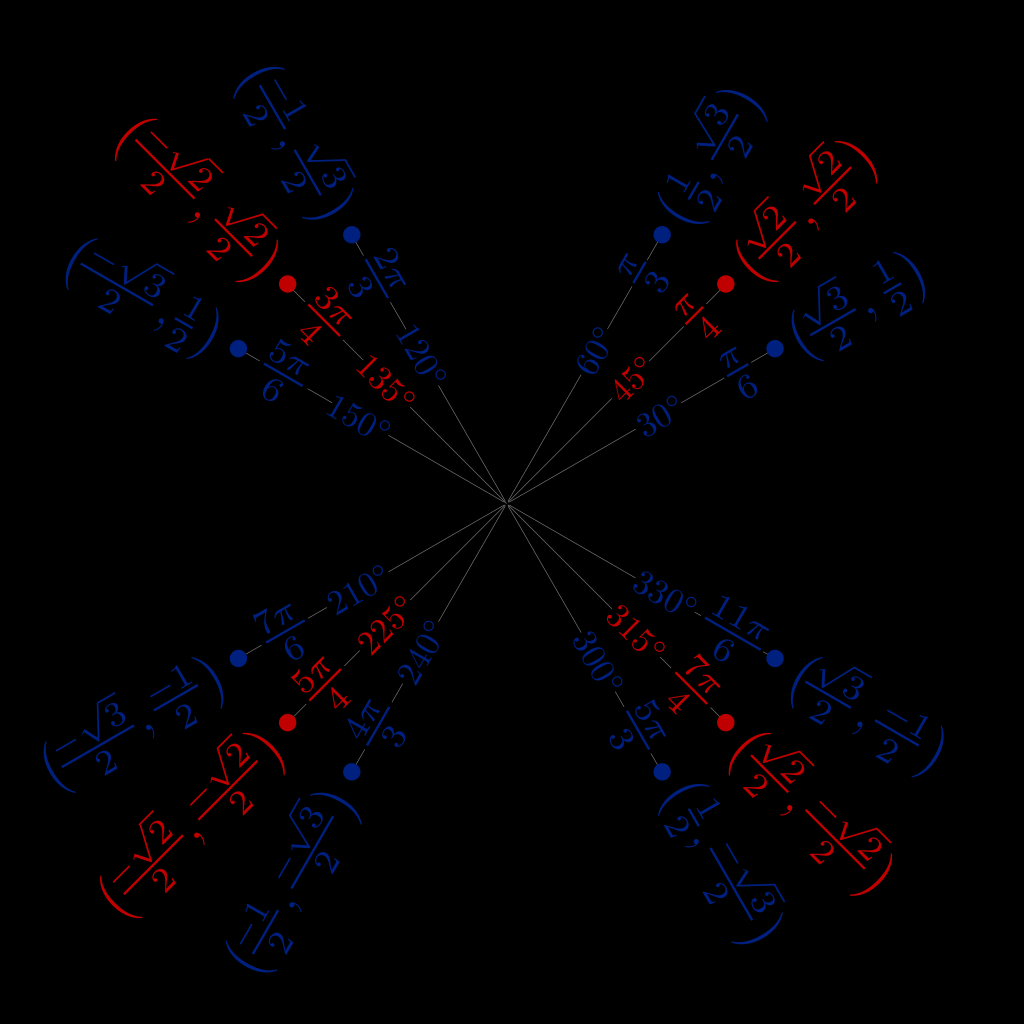

예상했던 대로, 데이터의 "year" 속성은 반복된다.
하지만 이 경우에는 진정한 주기적인 특성이 연속적인 방식으로 표현되지 않는다.
월과 일을 사인과 코사인 조합으로 나누면 주기적인 연속형 특징을 얻을 수 있다.
이러한 특징은 인공 신경망의 입력값으로 사용할 수 있다.

Text(0.5, 0, 'Sine Encoded Months')

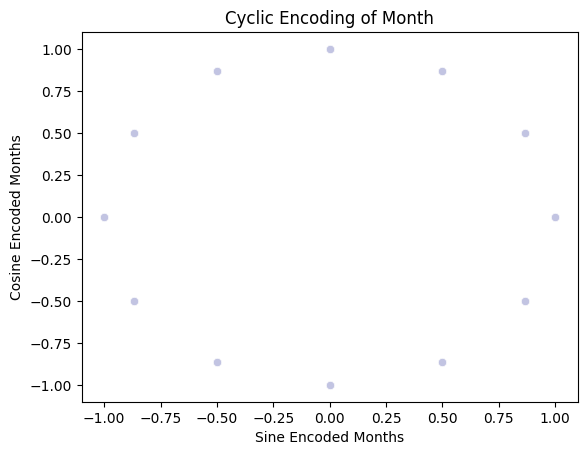

In [ ]:
cyclic_month=sns.scatterplot(x='month_sin', y='month_cos', data=df, color="#C2C4E2")
cyclic_month.set_title("Cyclic Encoding of Month")
cyclic_month.set_ylabel("Cosine Encoded Months")
cyclic_month.set_xlabel("Sine Encoded Months")

Text(0.5, 0, 'Sine Encoded Day')

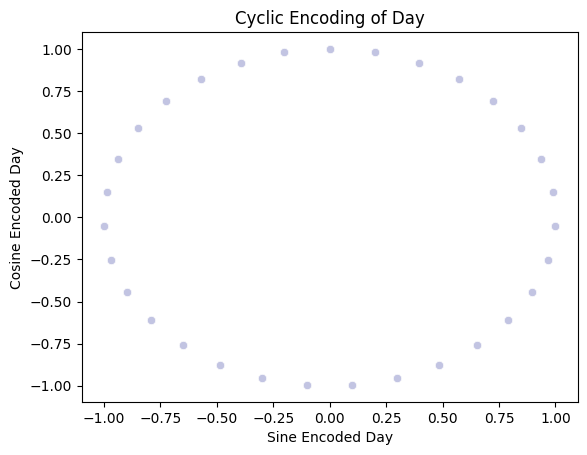

In [ ]:
cyclic_day=sns.scatterplot(x='day_sin', y='day_cos', data=df, color="#C2C4E2")
cyclic_day.set_title("Cyclic Encoding of Day")
cyclic_day.set_ylabel("Cosine Encoded Day")
cyclic_day.set_xlabel("Sine Encoded Day")

### 결측치 처리

범주형 데이터 - 최빈값 보완

In [ ]:
s = (df.dtypes == 'object')
object_cols = list(s[s].index)

print('Categorical variables:')
print(object_cols)

# df.select_dtypes(include='object').columns.tolist()와 동일 & 권장

Categorical variables:
['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']


In [ ]:
for i in object_cols:
    print(i, df[i].isnull().sum())

Location 0
WindGustDir 10326
WindDir9am 10566
WindDir3pm 4228
RainToday 3261
RainTomorrow 3267


In [ ]:
for i in object_cols:
    df[i].fillna(df[i].mode()[0],inplace=True)

<ipython-input-15-c108b181e27a>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[i].fillna(df[i].mode()[0],inplace=True)


수치형 변수 - 중간값 보완

In [ ]:
num_cols = df.select_dtypes(include='number').columns.tolist()

print('Numerical variables:')
print(num_cols)

Numerical variables:
['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'Year', 'month', 'month_sin', 'month_cos', 'day', 'day_sin', 'day_cos']


In [ ]:
for i in num_cols:
    print(i,df[i].isnull().sum())

MinTemp 1485
MaxTemp 1261
Rainfall 3261
Evaporation 62790
Sunshine 69835
WindGustSpeed 10263
WindSpeed9am 1767
WindSpeed3pm 3062
Humidity9am 2654
Humidity3pm 4507
Pressure9am 15065
Pressure3pm 15028
Cloud9am 55888
Cloud3pm 59358
Temp9am 1767
Temp3pm 3609
Year 0
month 0
month_sin 0
month_cos 0
day 0
day_sin 0
day_cos 0


In [ ]:
for i in num_cols:
    df[i].fillna(df[i].median(), inplace=True)

df.info()

<ipython-input-18-e829af663854>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[i].fillna(df[i].median(), inplace=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 30 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Date           145460 non-null  datetime64[ns]
 1   Location       145460 non-null  object        
 2   MinTemp        145460 non-null  float64       
 3   MaxTemp        145460 non-null  float64       
 4   Rainfall       145460 non-null  float64       
 5   Evaporation    145460 non-null  float64       
 6   Sunshine       145460 non-null  float64       
 7   WindGustDir    145460 non-null  object        
 8   WindGustSpeed  145460 non-null  float64       
 9   WindDir9am     145460 non-null  object        
 10  WindDir3pm     145460 non-null  object        
 11  WindSpeed9am   145460 non-null  float64       
 12  WindSpeed3pm   145460 non-null  float64       
 13  Humidity9am    145460 non-null  float64       
 14  Humidity3pm    145460 non-null  float64       
 15  

# 데이터 전처리
- 라벨인코딩
- 스케일링
- 이상치 감지 & 처리

라벨 인코딩

In [ ]:
label_encoder = LabelEncoder()
for i in object_cols:
    df[i] = label_encoder.fit_transform(df[i])
df.info()

# 어우...전부 다 라벨인코딩을 해버려도 상관없는건가?

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 30 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Date           145460 non-null  datetime64[ns]
 1   Location       145460 non-null  int64         
 2   MinTemp        145460 non-null  float64       
 3   MaxTemp        145460 non-null  float64       
 4   Rainfall       145460 non-null  float64       
 5   Evaporation    145460 non-null  float64       
 6   Sunshine       145460 non-null  float64       
 7   WindGustDir    145460 non-null  int64         
 8   WindGustSpeed  145460 non-null  float64       
 9   WindDir9am     145460 non-null  int64         
 10  WindDir3pm     145460 non-null  int64         
 11  WindSpeed9am   145460 non-null  float64       
 12  WindSpeed3pm   145460 non-null  float64       
 13  Humidity9am    145460 non-null  float64       
 14  Humidity3pm    145460 non-null  float64       
 15  

In [ ]:
features = df.drop(['RainTomorrow','Date','day','month'],axis=1)

target = df['RainTomorrow']

col_names = list(features.columns)
s_scaler = preprocessing.StandardScaler()
features = s_scaler.fit_transform(features)
features = pd.DataFrame(features,columns=col_names)

features.describe().T

,count,mean,std,min,25%,50%,75%,max
Location,145460.0,7.815677e-18,1.000003,-1.672228,-0.899139,0.014511,0.857881,1.701250
MinTemp,145460.0,-4.501830e-16,1.000003,-3.250525,-0.705659,-0.030170,0.723865,3.410112
MaxTemp,145460.0,3.001220e-16,1.000003,-3.952405,-0.735852,-0.086898,0.703133,3.510563
Rainfall,145460.0,7.815677e-18,1.000003,-0.275097,-0.275097,-0.275097,-0.203581,43.945571
Evaporation,145460.0,-3.282584e-17,1.000003,-1.629472,-0.371139,-0.119472,0.006361,43.985108
Sunshine,145460.0,-5.424080e-16,1.000003,-2.897217,0.076188,0.148710,0.257494,2.360634
WindGustDir,145460.0,6.252542e-18,1.000003,-1.724209,-0.872075,0.193094,1.045228,1.471296
WindGustSpeed,145460.0,1.824961e-16,1.000003,-2.588407,-0.683048,-0.073333,0.460168,7.243246
WindDir9am,145460.0,7.190423e-17,1.000003,-1.550000,-0.885669,0.000105,0.885879,1.771653
WindDir3pm,145460.0,8.284618e-17,1.000003,-1.718521,-0.837098,0.044324,0.925747,1.586813


<ipython-input-21-e7d7f61710c2>:6: UserWarning: 
The palette list has fewer values (5) than needed (26) and will cycle, which may produce an uninterpretable plot.
  sns.boxenplot(data = features,palette = colours)


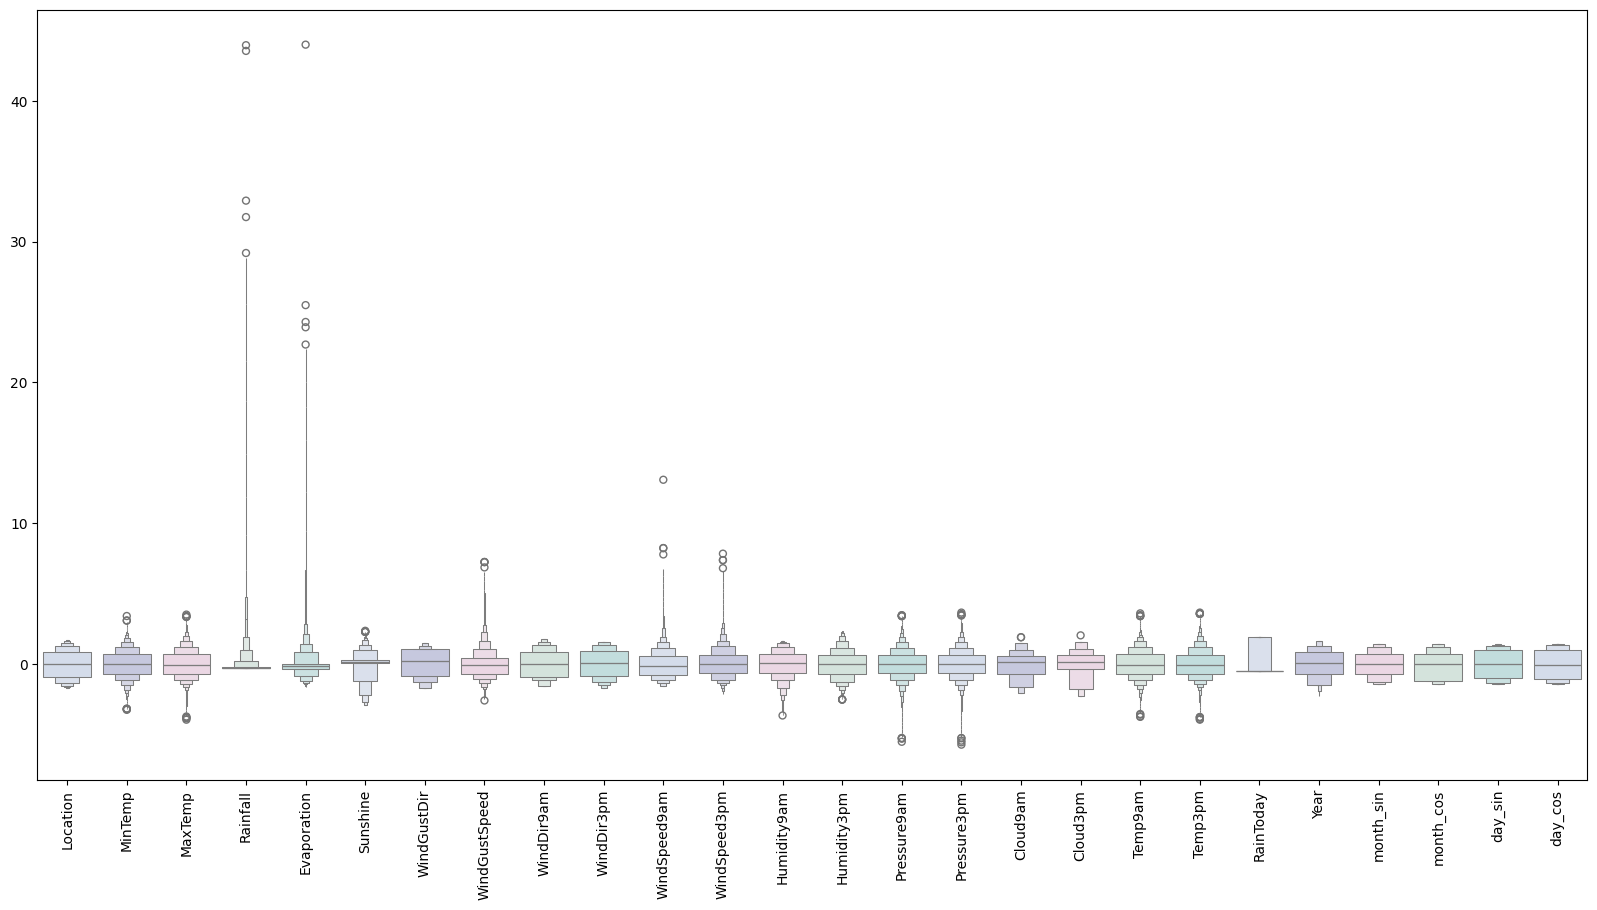

In [ ]:
#이상치 감지
#이상치 감지를 스케일링을 한 뒤에 하는것이 신기하다
plt.style.use('default')
colours = ["#D0DBEE", "#C2C4E2", "#EED4E5", "#D1E6DC", "#BDE2E2"]
plt.figure(figsize=(20,10))
sns.boxenplot(data = features,palette = colours)
plt.xticks(rotation=90)
plt.show()

In [ ]:
# 그냥 이상치 동그라미가 보인다싶으면 다 떨군듯.
# 하긴 정규화까지 했는데도 이상치면 이상치인게 확실하다 이건가?
# 흠... 근데 정규화할 때 이상치가 있으면 그게 반영돼서 잘되나...? 모르겠다 ㅠ
#full data for
features["RainTomorrow"] = target
features = features[(features["MinTemp"]<2.3)&(features["MinTemp"]>-2.3)]
features = features[(features["MaxTemp"]<2.3)&(features["MaxTemp"]>-2)]
features = features[(features["Rainfall"]<4.5)]
features = features[(features["Evaporation"]<2.8)]
features = features[(features["Sunshine"]<2.1)]
features = features[(features["WindGustSpeed"]<4)&(features["WindGustSpeed"]>-4)]
features = features[(features["WindSpeed9am"]<4)]
features = features[(features["WindSpeed3pm"]<2.5)]
features = features[(features["Humidity9am"]>-3)]
features = features[(features["Humidity3pm"]>-2.2)]
features = features[(features["Pressure9am"]< 2)&(features["Pressure9am"]>-2.7)]
features = features[(features["Pressure3pm"]< 2)&(features["Pressure3pm"]>-2.7)]
features = features[(features["Cloud9am"]<1.8)]
features = features[(features["Cloud3pm"]<2)]
features = features[(features["Temp9am"]<2.3)&(features["Temp9am"]>-2)]
features = features[(features["Temp3pm"]<2.3)&(features["Temp3pm"]>-2)]


features.shape

(127536, 27)

✅ 이상치 처리 기준(gpt가 생각하기엔 그렇다..~)

 |변수           | 기준         | 이유                                      |
|----------------|--------------|-------------------------------------------|
| MinTemp        | ±2.3         | 정규분포 근접, 일반적 기준                |
| Rainfall       | < 4.5        | 비정규분포, 우측 꼬리 짧게 자름           |
| Evaporation    | < 2.8        | 일부 큰 이상치 존재, 상한 제한            |
| Pressure3pm    | -2.7 ~ 2     | 비대칭 분포, 하한에 이상치 집중           |


<ipython-input-23-d3a7b3e4bca7>:2: UserWarning: 
The palette list has fewer values (5) than needed (27) and will cycle, which may produce an uninterpretable plot.
  sns.boxenplot(data = features,palette = colours)


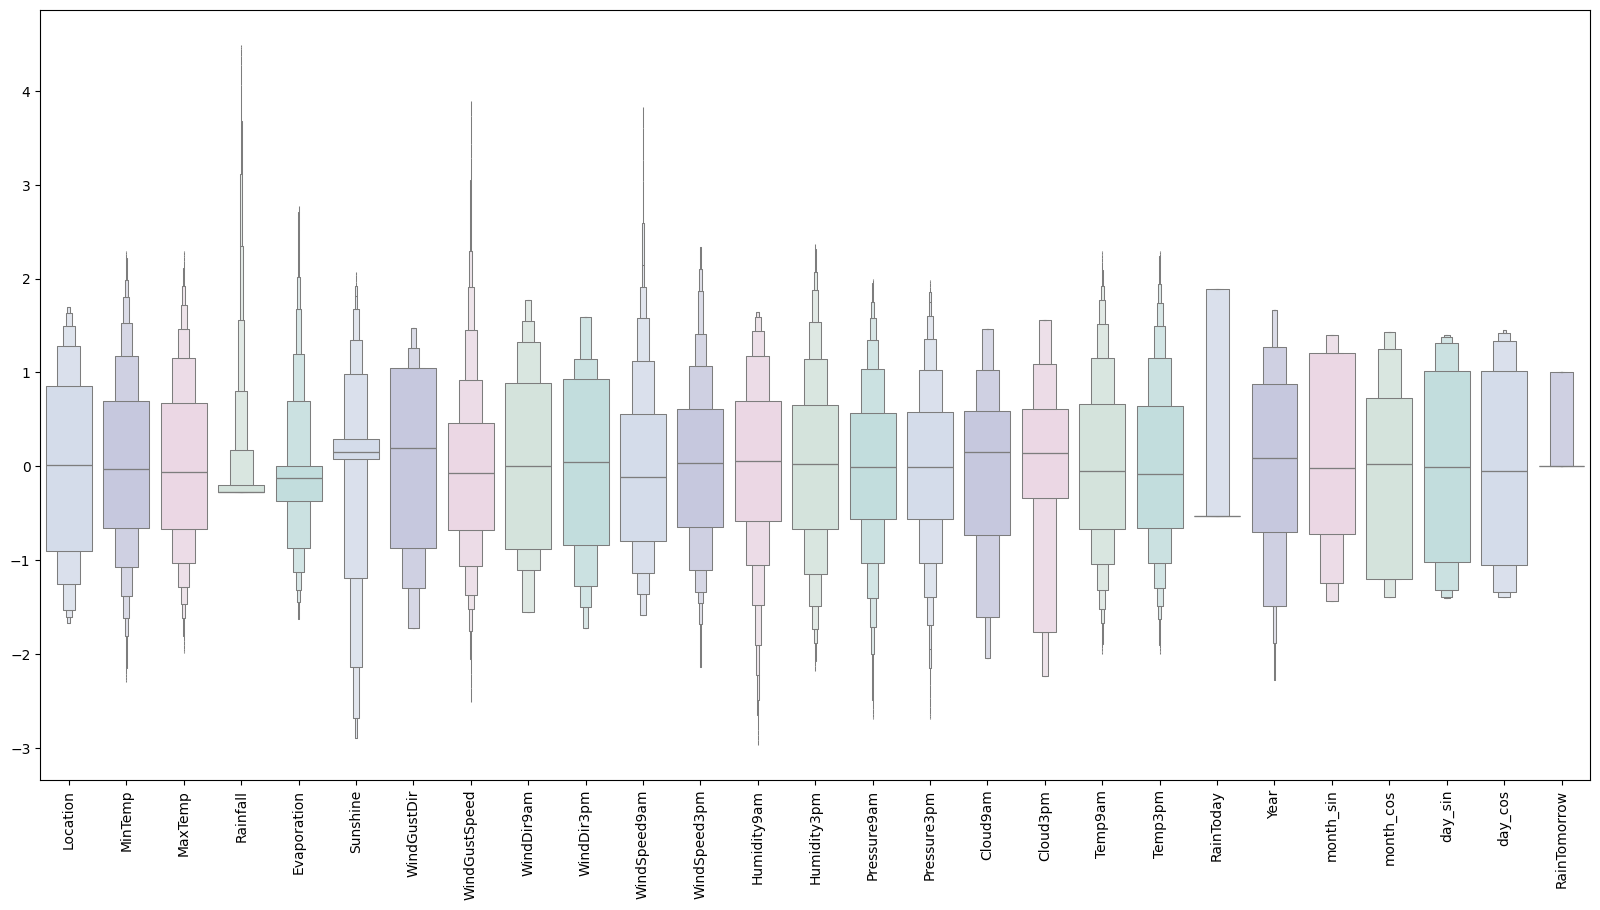

In [ ]:
plt.figure(figsize=(20,10))
sns.boxenplot(data = features,palette = colours)
plt.xticks(rotation=90)
plt.show()

# Model Building

- X와 y에 속성과 라벨 할당하기
- 데이터 나누기
- 신경망 초기화하기
- 레이어 추가해서 신경망 정의하기
- 신경망 합치기
- 신경망 학습시키기

In [ ]:
X = features.drop(['RainTomorrow'], axis=1)
y = features['RainTomorrow']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)

X.shape

(127536, 26)

In [ ]:
# 이진분류 문제에 대한 인공신경망(ANN) 모델 구축 및 훈련 파이프라인

#1. 조기종료(EarlyStopping)
early_stopping = callbacks.EarlyStopping(min_delta=0.001,       # 개선이 0.001이면 유효한 개선으로 간주
                                         patience=20,           # 개선이 없을 때 20epoch 기다렸다가 멈춤
                                         restore_best_weights=True) # 가장 성능이 좋았던 가중치를 복원

#2. 신경망 모델 구조 설계(Sequential)
model=Sequential() # 층(layer)을 순차적으로 쌓는 가장 단순한 신경망 구조

#3. 레이어 구성
model.add(Dense(units = 32, kernel_initializer = 'uniform', activation ='relu', input_dim = 26))
model.add(Dense(units = 32,  kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dense(units = 16, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(units = 8,  kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(units=1,  kernel_initializer = 'uniform', activation = 'sigmoid'))

#4. ANN합성하기
opt = Adam(learning_rate = 0.0009)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics= ['accuracy'])

#5. ANN합성하기
history = model.fit(X_train, y_train, batch_size=32, epochs=150, callbacks=[early_stopping], validation_split=0.2)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/150
2551/2551 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.7859 - loss: 0.4515 - val_accuracy: 0.8419 - val_loss: 0.3797
Epoch 2/150
2551/2551 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.8369 - loss: 0.4041 - val_accuracy: 0.8401 - val_loss: 0.3764
Epoch 3/150
2551/2551 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.8407 - loss: 0.3999 - val_accuracy: 0.8421 - val_loss: 0.3753
Epoch 4/150
2551/2551 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.8401 - loss: 0.3983 - val_accuracy: 0.8417 - val_loss: 0.3721
Epoch 5/150
2551/2551 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.8423 - loss: 0.3983 - val_accuracy: 0.8433 - val_loss: 0.3713
Epoch 6/150
2551/2551 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.8440 - loss: 0.3931 - val_accuracy: 0.8407 - val_loss: 0.3720
Epoch 7/150
2551/2551 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.8415 - loss: 0.3966 - val_accuracy: 0.8447 - val_loss: 0.3692
Epoch 8/150
2551/2551 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.8438 - loss

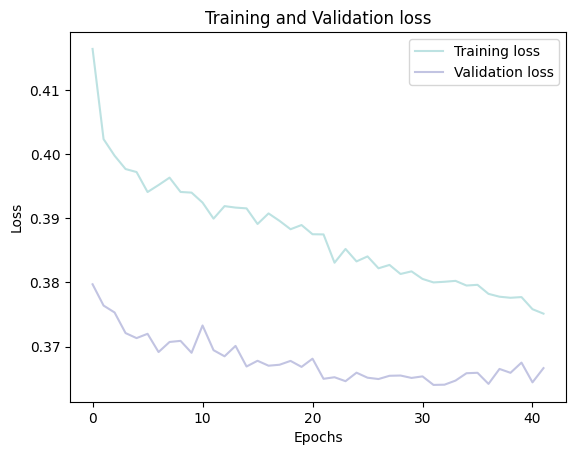

In [ ]:
history_df = pd.DataFrame(history.history)

plt.plot(history_df.loc[:, ['loss']], "#BDE2E2", label='Training loss')
plt.plot(history_df.loc[:, ['val_loss']],"#C2C4E2", label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="best")

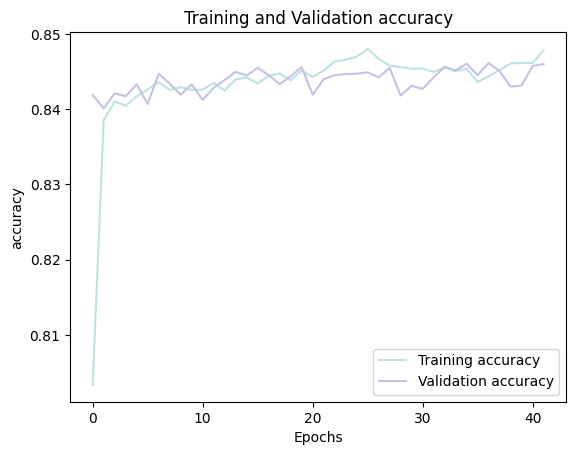

In [ ]:
history_df = pd.DataFrame(history.history)

plt.plot(history_df.loc[:, ['accuracy']], "#BDE2E2", label='Training accuracy')
plt.plot(history_df.loc[:, ['val_accuracy']],"#C2C4E2", label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend(loc="best")

#Conclusion

- 테스트 셋트로 테스트 진행하기
- 혼돈 행렬 평가하기
- 분류 리포트 평가하기

In [ ]:
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)

798/798 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


<Axes: >

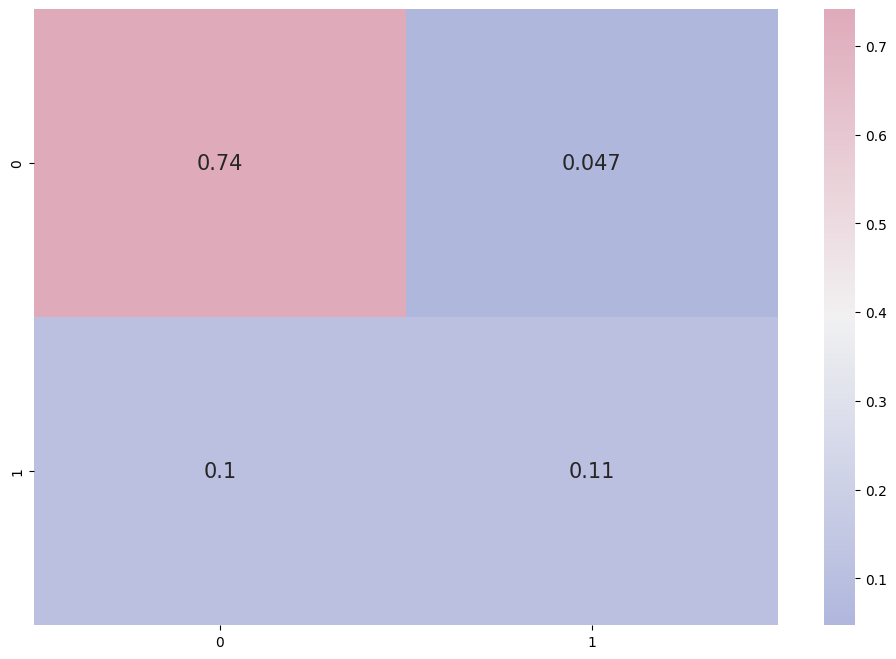

In [ ]:
# confusion matrix

cmap1 = sns.diverging_palette(260,-10,s=50, l=75, n=5, as_cmap=True)
plt.subplots(figsize=(12,8))
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix/np.sum(cf_matrix), cmap = cmap1, annot=True, annot_kws = {'size':15})

- cf_matrix / np.sum(cf_matrix) : 전체 합을 나누어 비율 형태로 표현
    - cf_matrix: 혼동행렬([[TN, FP],
 [FN, TP]]
    
    = [[90, 10], [5, 95]]

    - np.sum(cf_matrix): 혼동 행렬 안의 모든 값을 다 더한 총 샘플 수

    = 90 + 10 + 5 + 95 = 200

    ➡️ 이 과정을 통해서 전체 예측 중 어떤 비율로 정답/오답이 발생했는지를 직관적으로 알 수 있음.

- annot_kws = {'size':15} : 셀 안에 표시할 숫자 폰트 크기 설정


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.94      0.91     20110
           1       0.69      0.50      0.58      5398

    accuracy                           0.85     25508
   macro avg       0.78      0.72      0.75     25508
weighted avg       0.84      0.85      0.84     25508

